# Stats Compass Core - Demo Notebook

This notebook demonstrates the core functionality of stats-compass-core.

In [1]:
# Import the package
import numpy as np
import pandas as pd

from stats_compass_core import DataFrameState, registry

# Initialize state
state = DataFrameState()
print("Stats Compass Core loaded successfully!")

Stats Compass Core loaded successfully!


## Create Sample Data

In [2]:
# Create sample DataFrame
np.random.seed(42)
df = pd.DataFrame({
    'age': np.random.randint(18, 65, 100),
    'income': np.random.normal(50000, 15000, 100),
    'category': np.random.choice(['A', 'B', 'C', 'D', 'Rare1', 'Rare2'], 100, p=[0.3, 0.3, 0.2, 0.1, 0.05, 0.05]),
    'target': np.random.randint(0, 2, 100)
})

# Add some missing values
df.loc[5:10, 'income'] = np.nan

# Store in state
state.set_dataframe(df, name="sample_data", operation='sample_data')
print(f"Loaded DataFrame with {len(df)} rows")
df.head()

Loaded DataFrame with 100 rows


,age,income,category,target
0,56,59544.576625,A,0
1,46,36399.189971,Rare2,0
2,32,57140.638811,B,1
3,60,69554.919026,A,0
4,25,53173.805185,Rare2,1


## List Available Tools

In [3]:
# Discover available tools
registry.auto_discover()
tools = registry.list_tools()
print(f"Available tools: {len(tools)}")
for tool in tools[:10]:
    print(f"  - {tool.name} ({tool.category})")

Available tools: 37
  - load_csv (data)
  - get_schema (data)
  - get_sample (data)
  - list_dataframes (data)
  - apply_imputation (cleaning)
  - dedupe (cleaning)
  - drop_na (cleaning)
  - handle_outliers (cleaning)
  - groupby_aggregate (transforms)
  - pivot (transforms)


## Data Tools

In [4]:
# Get schema
from stats_compass_core.data.get_schema import GetSchemaInput, get_schema

schema_result = get_schema(state, GetSchemaInput())
print(f"DataFrame: {schema_result.dataframe_name}")
print(f"Shape: {schema_result.shape[0]} rows x {schema_result.shape[1]} columns")
print("\nColumns:")
for col in schema_result.columns:
    print(f"  {col['name']}: {col['dtype']} (nulls: {col['null_count']})")

DataFrame: sample_data
Shape: 100 rows x 4 columns

Columns:
  age: int64 (nulls: 0)
  income: float64 (nulls: 6)
  category: object (nulls: 0)
  target: int64 (nulls: 0)


## Cleaning Tools

In [5]:
# Apply imputation
from stats_compass_core.cleaning.apply_imputation import (
    ApplyImputationInput,
    apply_imputation,
)

result = apply_imputation(state, ApplyImputationInput(
    columns=['income'],
    strategy='mean',
    save_as='cleaned_data'
))
print(f"Imputed {result.rows_affected} values")
print(f"New DataFrame saved as: {result.dataframe_name}")

Imputed 6 values
New DataFrame saved as: cleaned_data


In [14]:
state.get_dataframe(name="cleaned_data")


,age,income,category,target
0,56,59544.576625,A,0
1,46,36399.189971,Rare2,0
2,32,57140.638811,B,1
3,60,69554.919026,A,0
4,25,53173.805185,Rare2,1
...,...,...,...,...
95,24,63099.754536,D,1
96,26,53084.752010,A,1
97,41,28347.749725,B,0
98,18,34584.337039,B,0


## Transform Tools

In [15]:
# Bin rare categories
from stats_compass_core.transforms.bin_rare_categories import (
    BinRareCategoriesInput,
    bin_rare_categories,
)

result = bin_rare_categories(state, BinRareCategoriesInput(
    dataframe_name='cleaned_data',
    categorical_columns=['category'],
    threshold=0.1,
    save_as='binned_data'
))
print(f"Binned rare categories in {len(result.columns_modified)} columns")
print(f"Binning details: {result.binning_details}")

Binned rare categories in 1 columns
Binning details: {'category': {'categories_before': 6, 'categories_after': 5, 'rare_categories': ['Rare2', 'Rare1'], 'rare_categories_count': 2, 'rows_affected': 13, 'total_rows': 100, 'percent_affected': 13.0}}


In [16]:
state.get_dataframe(name="binned_data")

,age,income,category,target
0,56,59544.576625,A,0
1,46,36399.189971,Other,0
2,32,57140.638811,B,1
3,60,69554.919026,A,0
4,25,53173.805185,Other,1
...,...,...,...,...
95,24,63099.754536,D,1
96,26,53084.752010,A,1
97,41,28347.749725,B,0
98,18,34584.337039,B,0


## EDA Tools

In [17]:
# Compute correlations
from stats_compass_core.eda.correlations import CorrelationsInput, correlations

corr_result = correlations(state, CorrelationsInput(
    dataframe_name='binned_data',
    method='pearson'
))
print(f"Correlation matrix ({corr_result.method}):")
print(f"Columns: {corr_result.columns}")
corr_result

Correlation matrix (pearson):
Columns: ['age', 'income', 'target']


CorrelationsResult(correlations={'age': {'age': 1.0, 'income': 0.03524359471548069, 'target': -0.10616540179459373}, 'income': {'age': 0.03524359471548069, 'income': 1.0, 'target': 0.19789837739668248}, 'target': {'age': -0.10616540179459373, 'income': 0.19789837739668248, 'target': 1.0}}, method='pearson', dataframe_name='binned_data', columns=['age', 'income', 'target'], high_correlations=None)

## Plot Tools

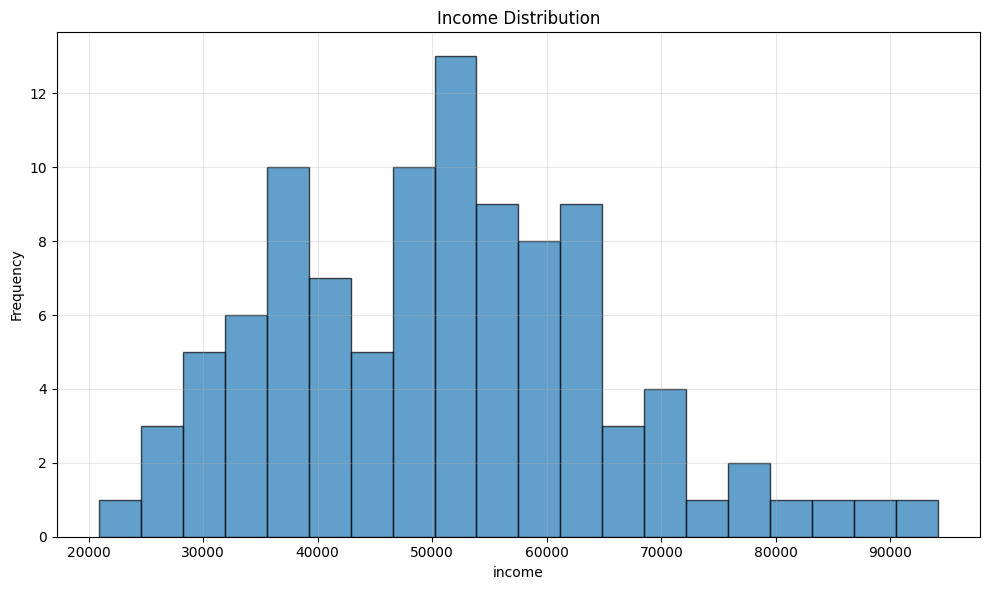

In [18]:
# Create histogram
import base64

from IPython.display import Image, display

from stats_compass_core.plots.histogram import HistogramInput, histogram

hist_result = histogram(state, HistogramInput(
    dataframe_name='binned_data',
    column='income',
    bins=20,
    title='Income Distribution'
))

# Display the plot
display(Image(data=base64.b64decode(hist_result.image_base64)))

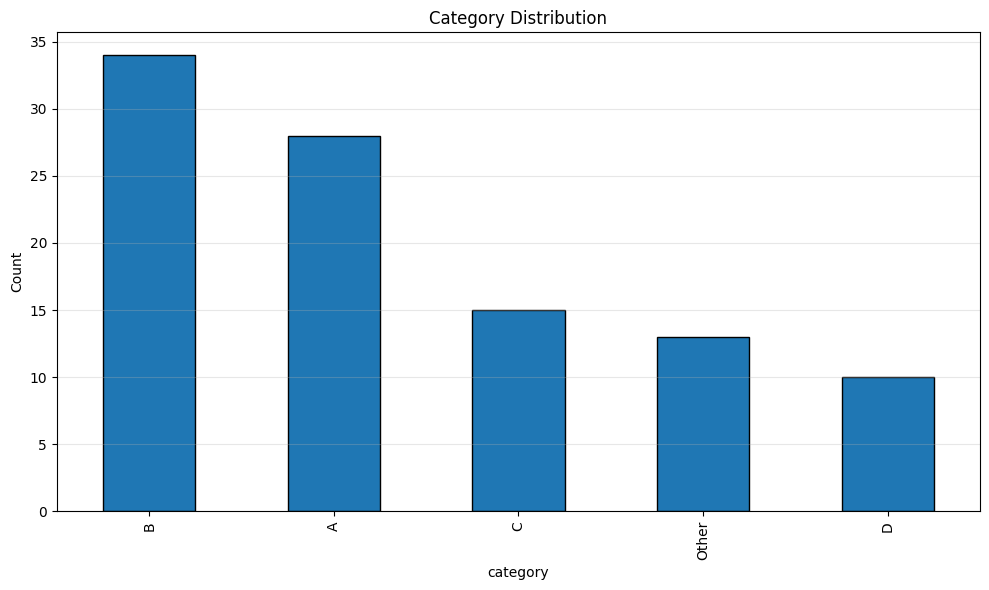

In [19]:
# Create bar chart
from stats_compass_core.plots.bar_chart import BarChartInput, bar_chart

bar_result = bar_chart(state, BarChartInput(
    dataframe_name='binned_data',
    column='category',
    title='Category Distribution'
))

display(Image(data=base64.b64decode(bar_result.image_base64)))

## State Summary

In [27]:
# Check state
summary = state.get_state_summary()
print(f"DataFrames in state: {len(summary['dataframes'])}")
for name in [df_dict["name"] for df_dict in summary['dataframes']] :
    print(f"  - {name}")
print(f"\nActive DataFrame: {summary["active_dataframe"]}")
print(f"Memory used: {summary['memory']['used_mb']:.2f} MB")

DataFrames in state: 3
  - sample_data
  - cleaned_data
  - binned_data

Active DataFrame: binned_data
Memory used: 0.02 MB
